In [95]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## Correlación: fluorescencia - motilidad

encodes (172, 100)
tracks (3518, 5)
ids 172
frames 118
km.labels_ 172


<ipython-input-96-36d9d246d73a>:24: RuntimeWarning: Mean of empty slice
  mean_fluorescence.append(np.nanmean(tracks[tracks[:, 0] == track_id][:, 3]))


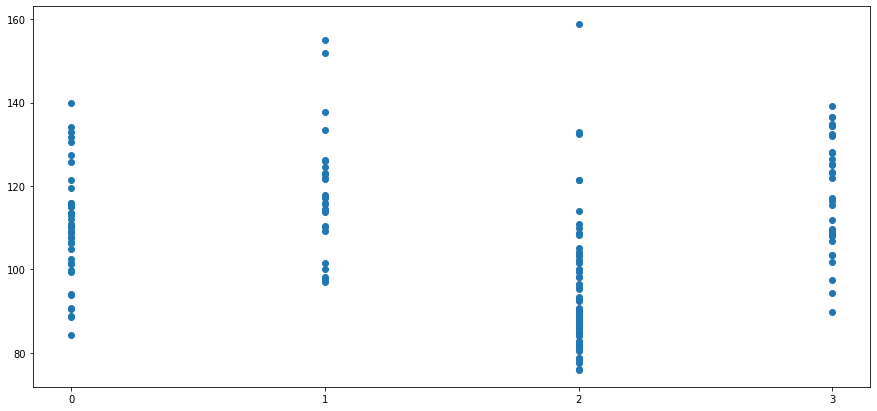

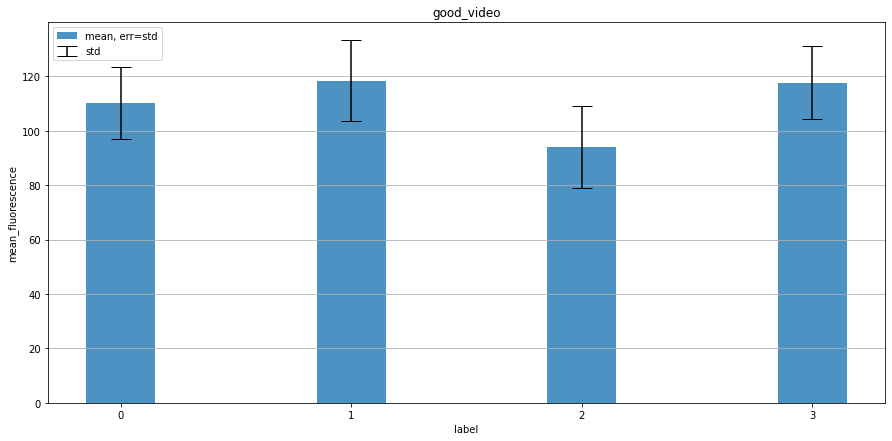

In [96]:
video = 'good_video'
encodes = np.load('data/individual/' + video + '/encodes.npy')
print('encodes', encodes.shape)

tracks = np.genfromtxt('data/individual/' + video + '/tracks.csv', delimiter=',', skip_header=True)
print('tracks', tracks.shape)
ids = np.unique(tracks[:, 0])
print('ids', len(ids))
frames = np.unique(tracks[:, 4])
print('frames', len(frames))
# id,x,y,fluorescence,frame

km = KMeans(n_clusters=4)
km.fit(encodes)
# print(km.labels_)
print('km.labels_', len(km.labels_))

tracks_info = pd.DataFrame(columns=['id', 'label', 'mean_fluorescence'])
tracks_info['id'] = ids
tracks_info['label'] = km.labels_
# print(tracks_info)
mean_fluorescence = []
for k, track_id in enumerate(ids):
    mean_fluorescence.append(np.nanmean(tracks[tracks[:, 0] == track_id][:, 3]))
tracks_info['mean_fluorescence'] = mean_fluorescence
# print(tracks_info)
fig = plt.figure(figsize=(15, 7))
plt.scatter(tracks_info['label'], tracks_info['mean_fluorescence'])
plt.xticks([0, 1, 2, 3])
plt.show()

labels_groups = tracks_info.groupby('label')['mean_fluorescence'].describe()
# print(labels_groups)
width = 0.3
fig = plt.figure(figsize=(15, 7))
ax = fig.gca()
# ax.bar(labels_groups.index + width*(-2), labels_groups['min'], width, label='min')
ax.bar(labels_groups.index + width*(0), labels_groups['mean'], width, label='mean, err=std', alpha=0.8)
ax.errorbar(labels_groups.index, labels_groups['mean'], yerr = labels_groups['std'], label='std',
            fmt=' ', ecolor='k', capsize=10)
# ax.bar(labels_groups.index + width*(0), labels_groups['50%'], width, label='median')
# ax.bar(labels_groups.index + width*(1), labels_groups['max'], width, label='max')
ax.yaxis.grid(True)
plt.xticks([0, 1, 2, 3])
plt.legend()
plt.title(video)
ax.set_xlabel('label')
ax.set_ylabel('mean_fluorescence')
plt.show()
fig.savefig('data/individual/' + video + '/mean_fluorescence.png')

## Casificación en función de la motilidad

encodes shape: (172, 100)


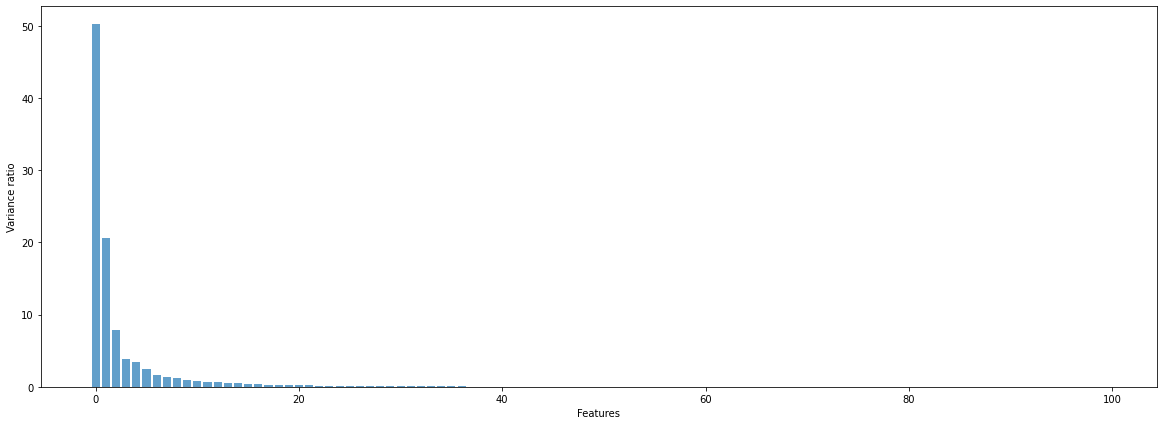

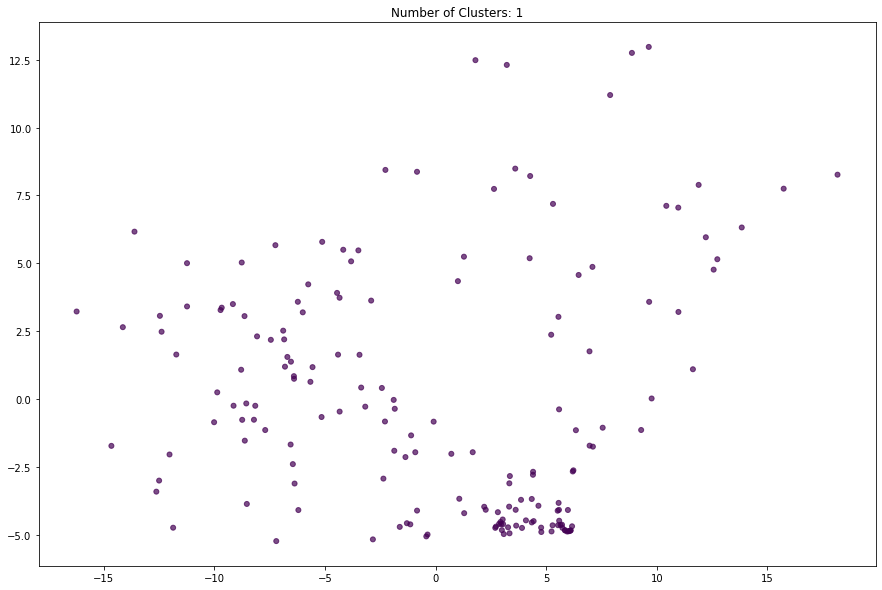

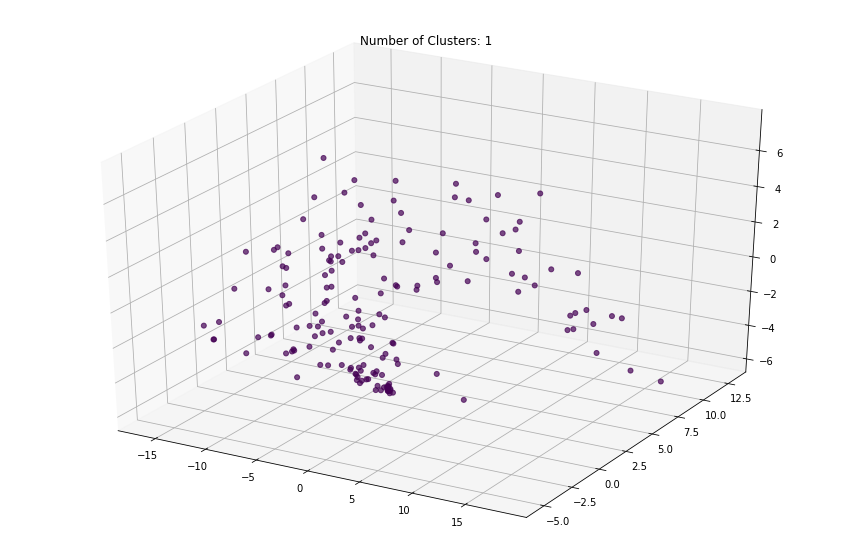

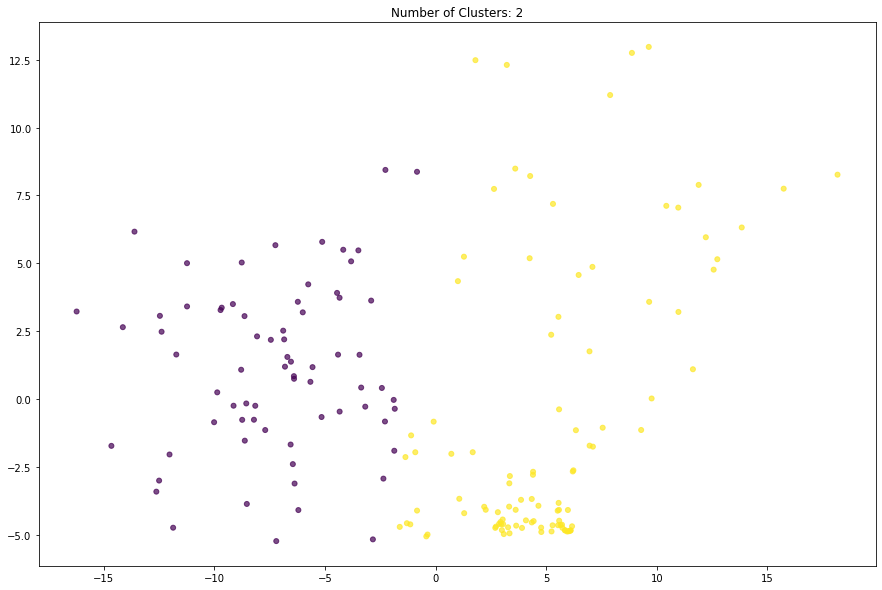

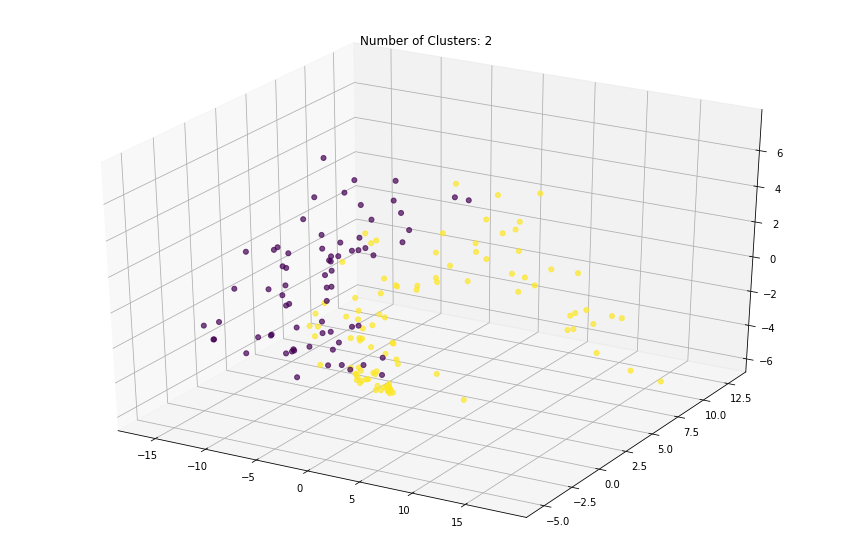

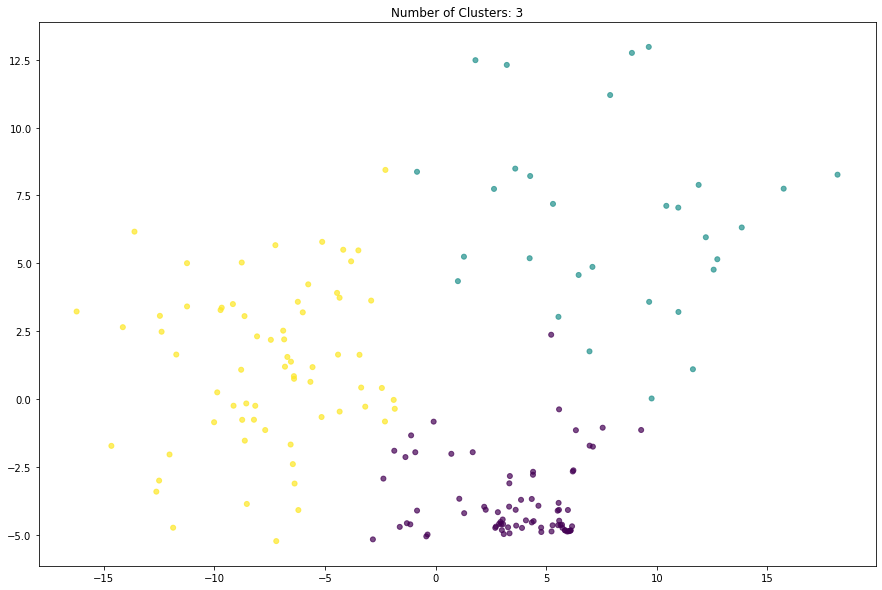

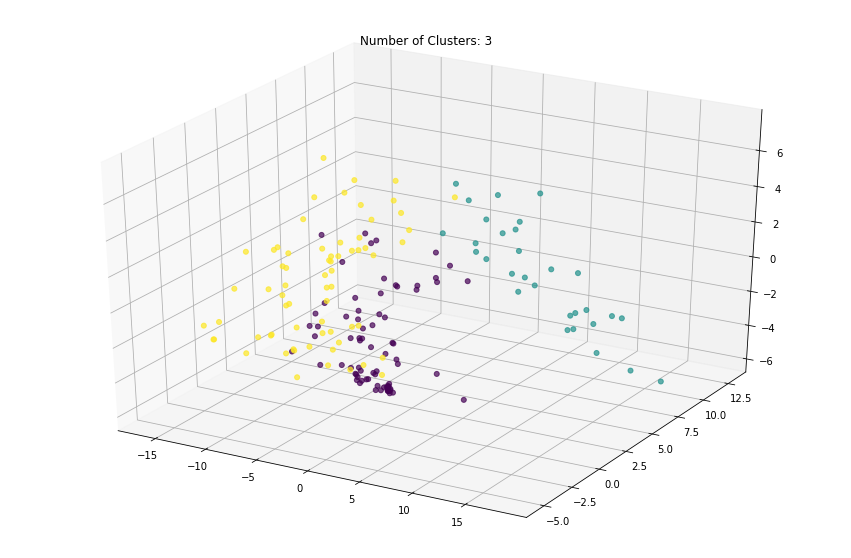

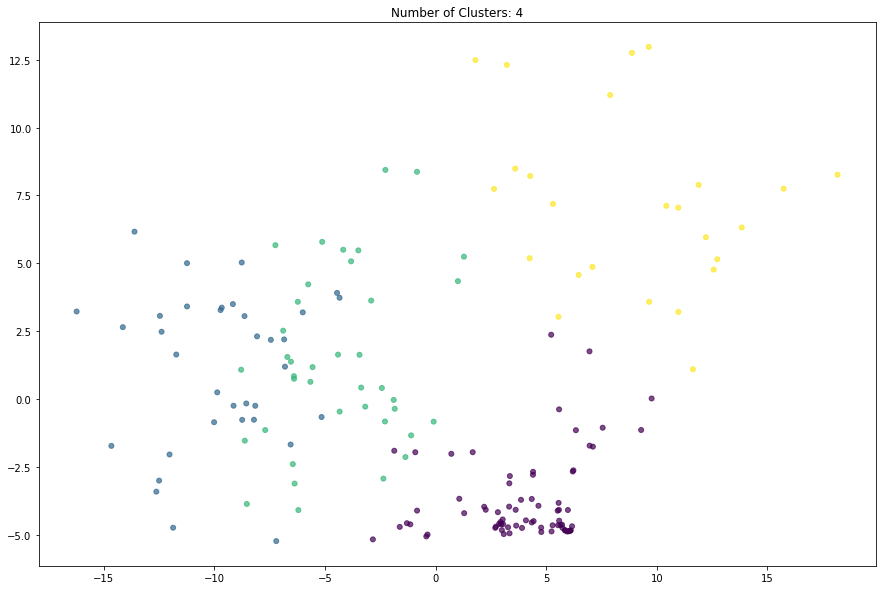

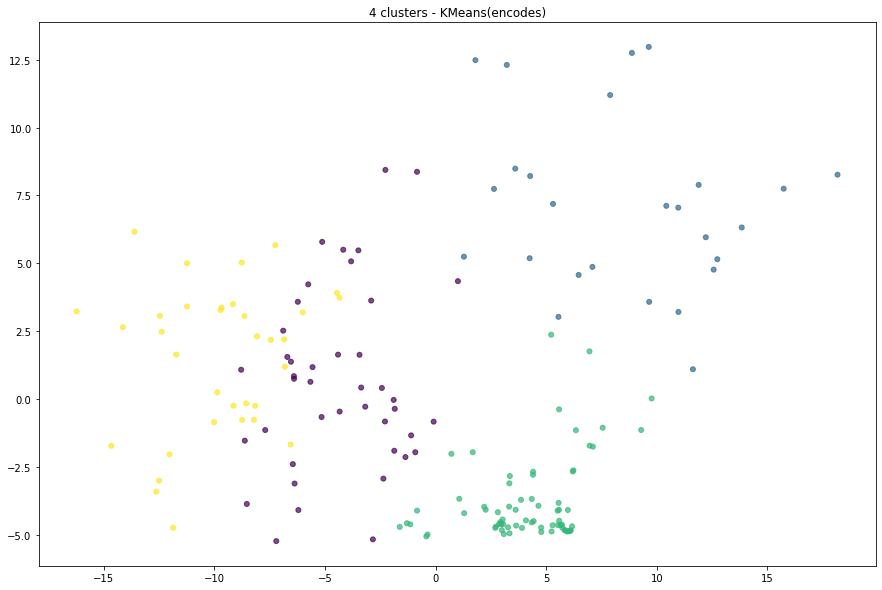

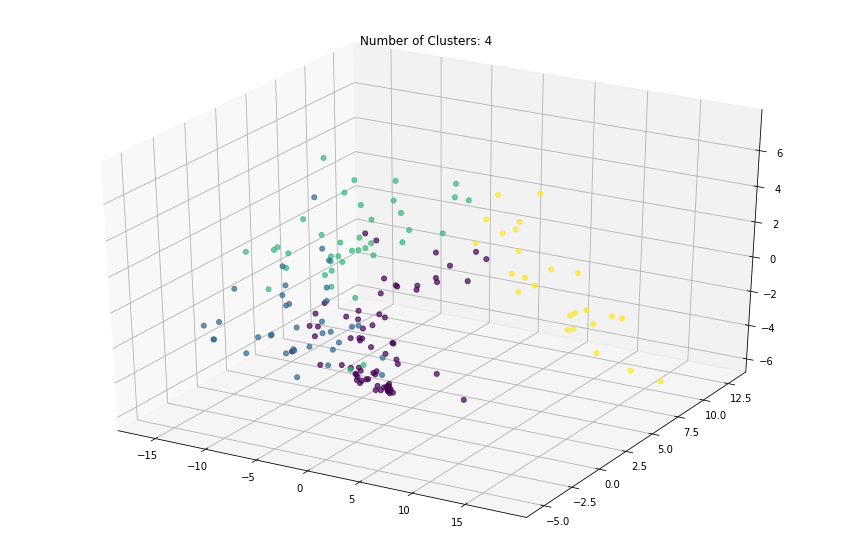

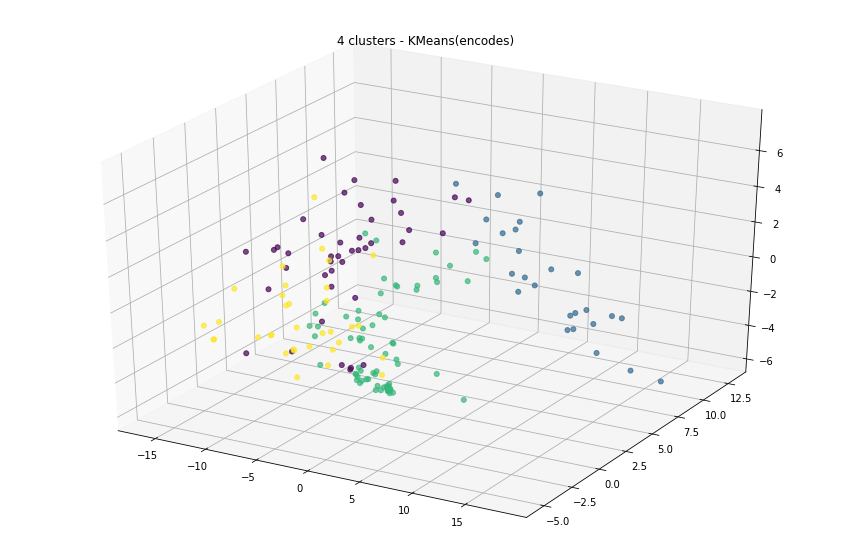

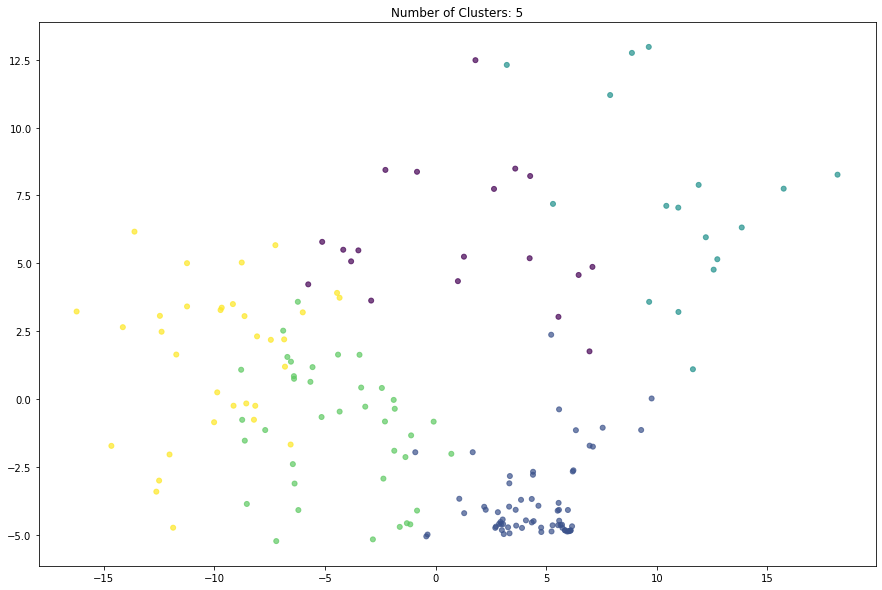

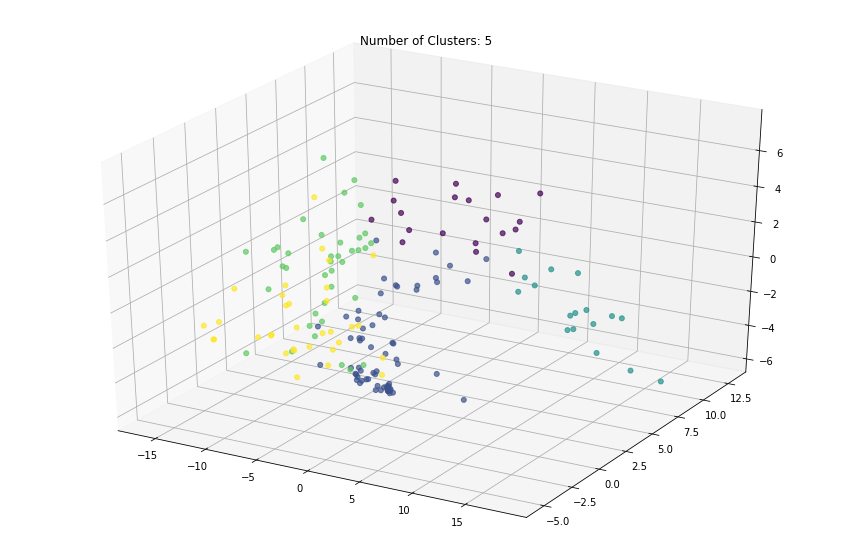

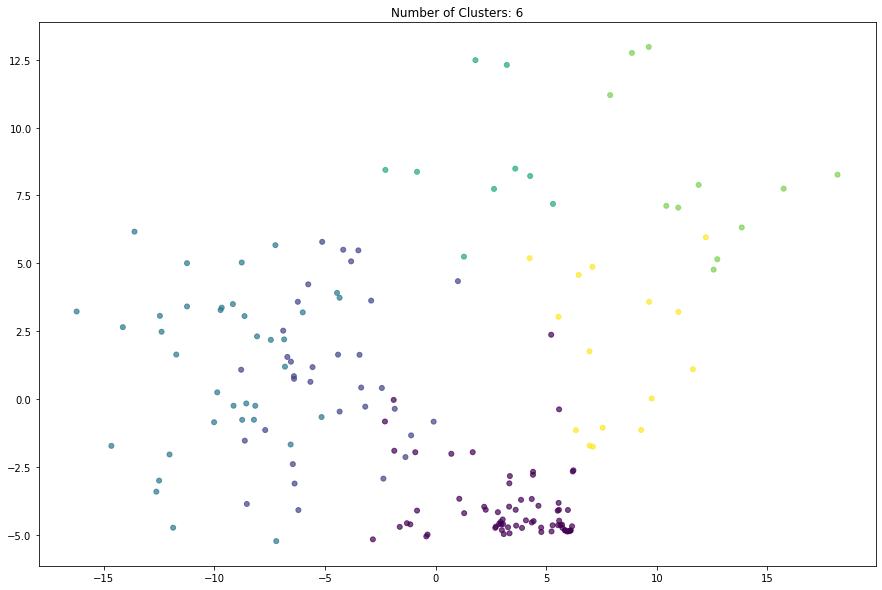

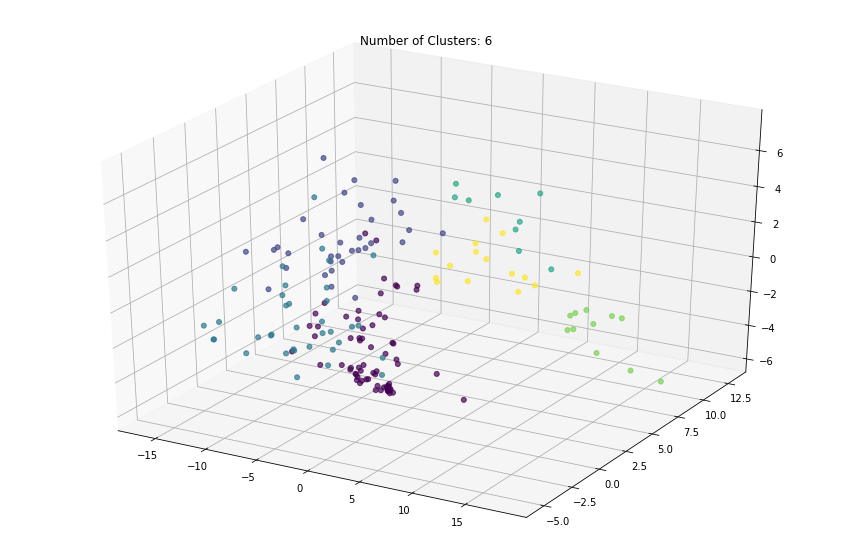

In [103]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
print('encodes shape:', encodes.shape)
# normalize
scaler = StandardScaler()
measures_scaled = scaler.fit_transform(encodes)
# features variance
pca = PCA()
measures_scaled = pca.fit_transform(measures_scaled)
pca_variance = pca.explained_variance_

plt.figure(figsize=(20, 7))
plt.bar(range(len(pca_variance)), pca_variance, alpha=0.7)
plt.ylabel('Variance ratio')
plt.xlabel('Features')
plt.show()

for i in range(1, 7):
    plt.figure(figsize=(15, 10))
    y_pred = KMeans(n_clusters=i).fit_predict(measures_scaled)
    plt.scatter(measures_scaled[:, 0], measures_scaled[:, 1], c=y_pred, s=25, alpha=0.7)
    plt.title(f"Number of Clusters: {i}")
    if i == 4:
        plt.figure(figsize=(15, 10))
        plt.scatter(measures_scaled[:, 0], measures_scaled[:, 1], c=km.labels_, s=25, alpha=0.7)
        plt.title(f"4 clusters - KMeans(encodes)")    
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(measures_scaled[:, 0], measures_scaled[:, 1], measures_scaled[:, 2], c=y_pred, s=25, alpha=0.7)
    plt.title(f"Number of Clusters: {i}")
    
    if i == 4:
        fig = plt.figure(figsize=(15, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(measures_scaled[:, 0], measures_scaled[:, 1], measures_scaled[:, 2], c=km.labels_, s=25, alpha=0.7)
        plt.title(f"4 clusters - KMeans(encodes)")
        plt.show()

plt.show();    

encodes size: (172, 100)
mean_fluorescence len: 172
encodes_fluo size (not nan): (168, 101)


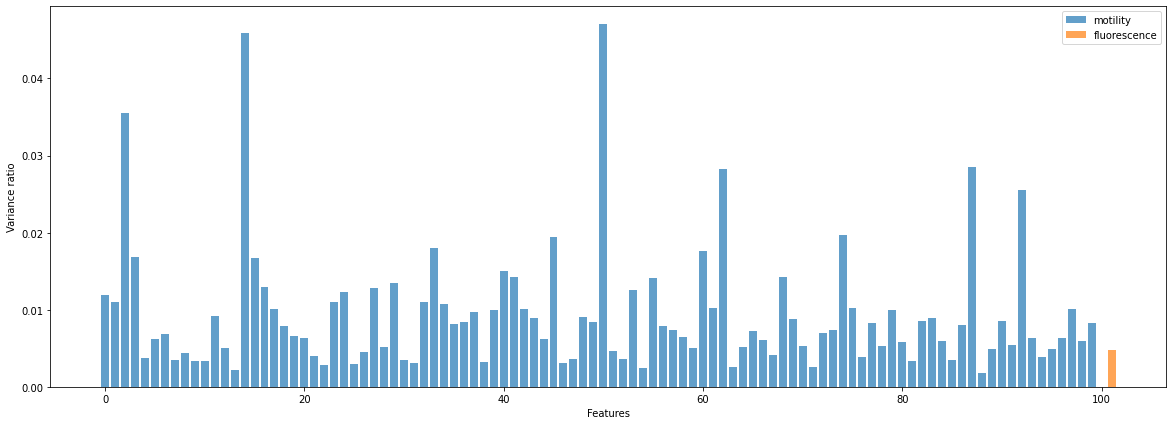

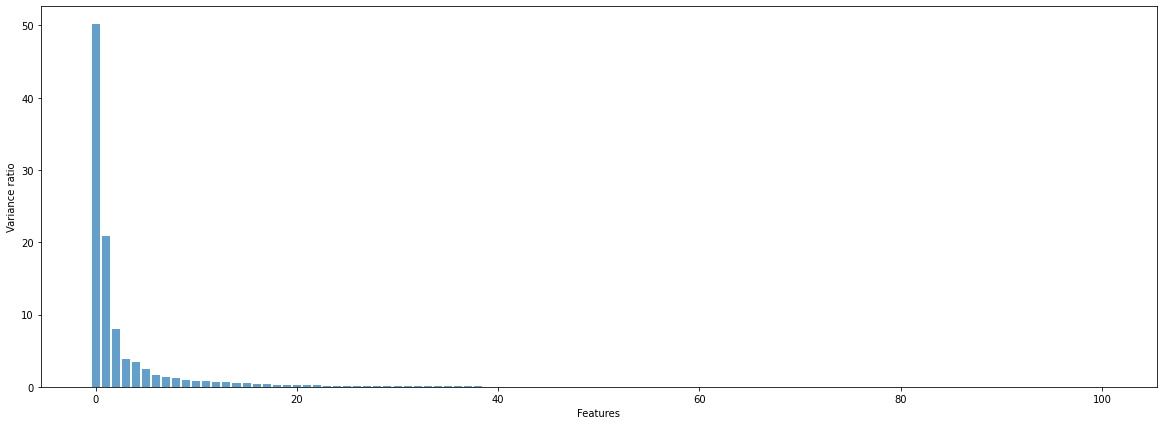

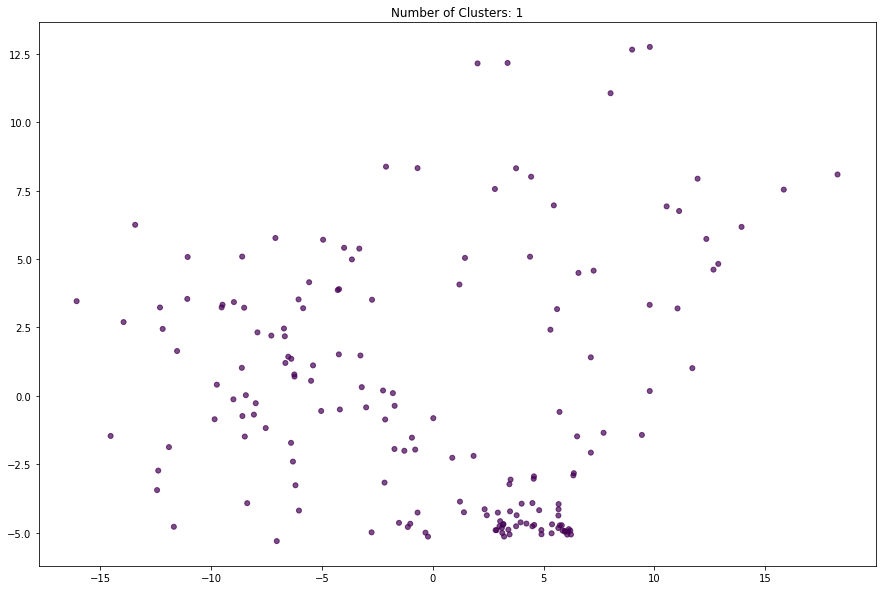

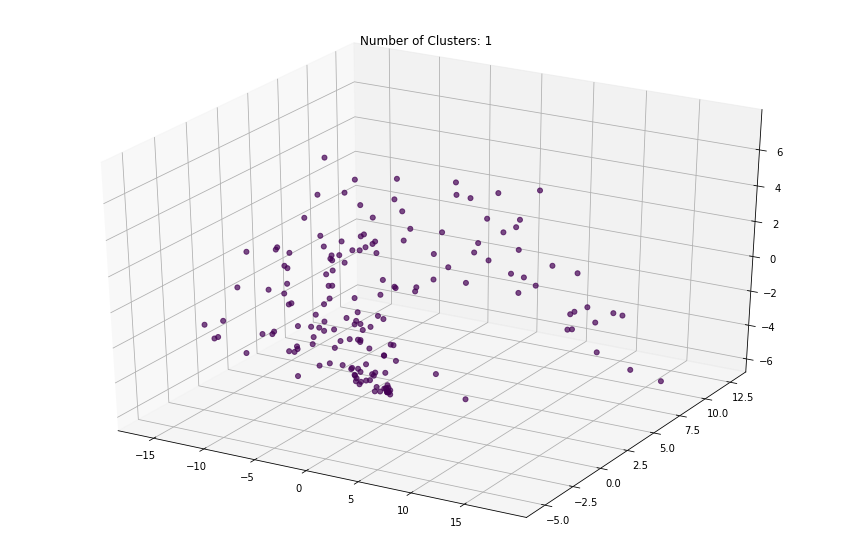

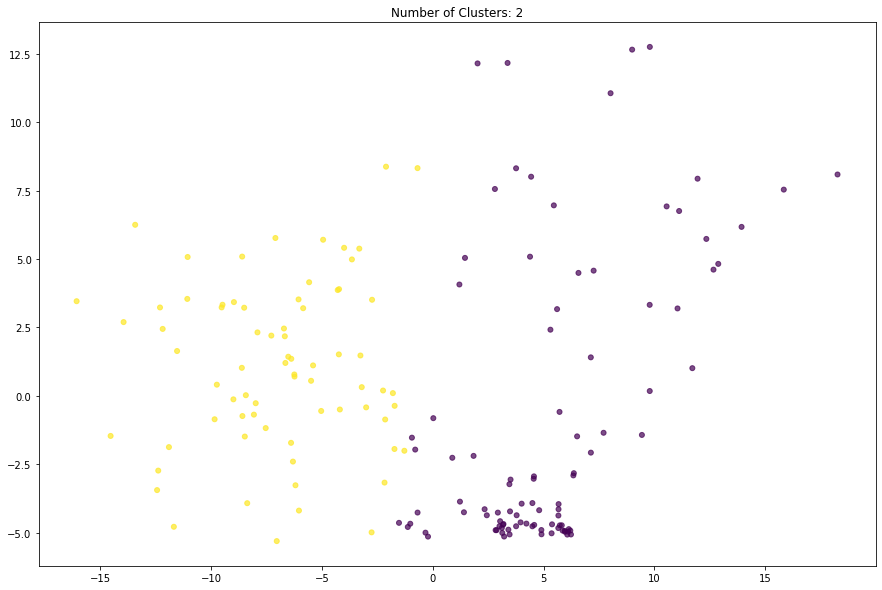

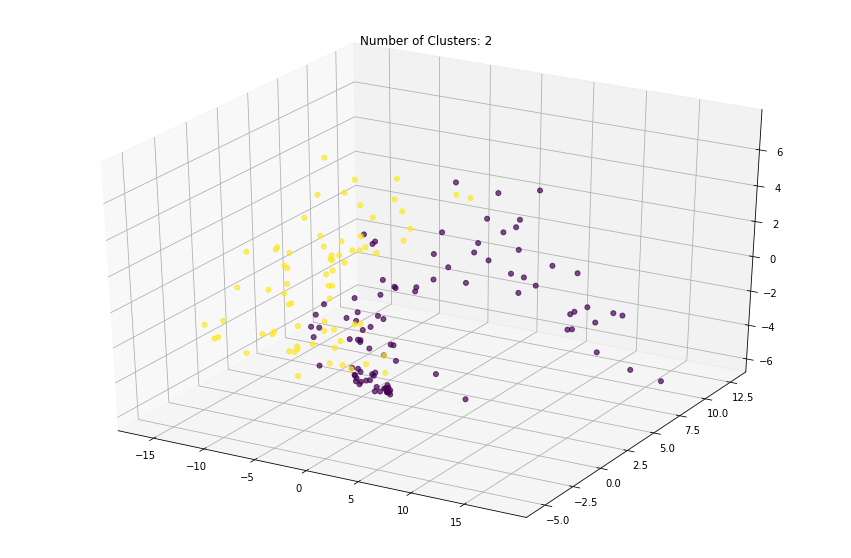

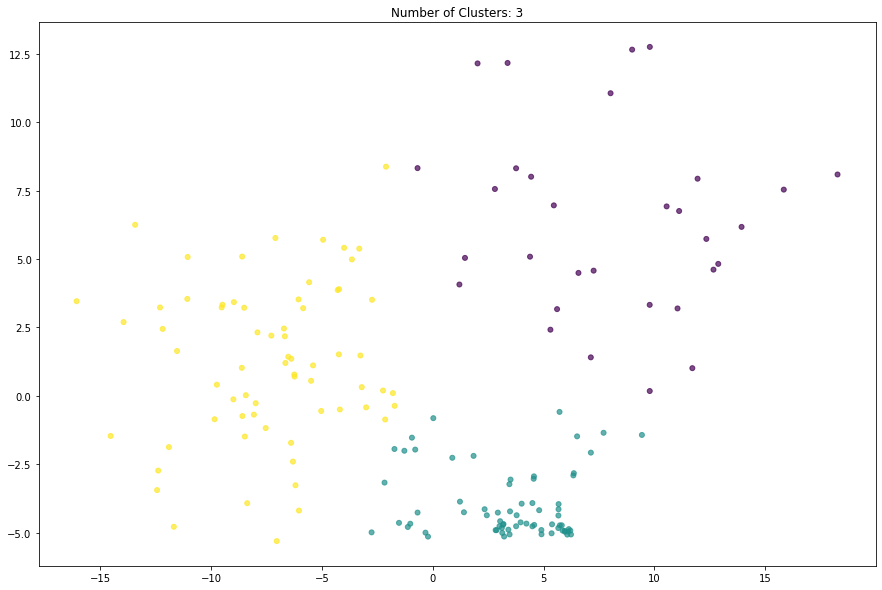

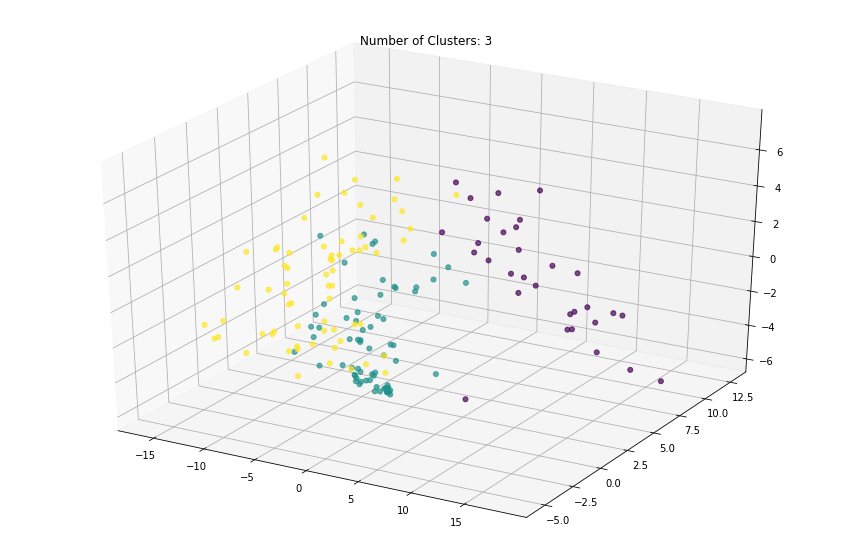

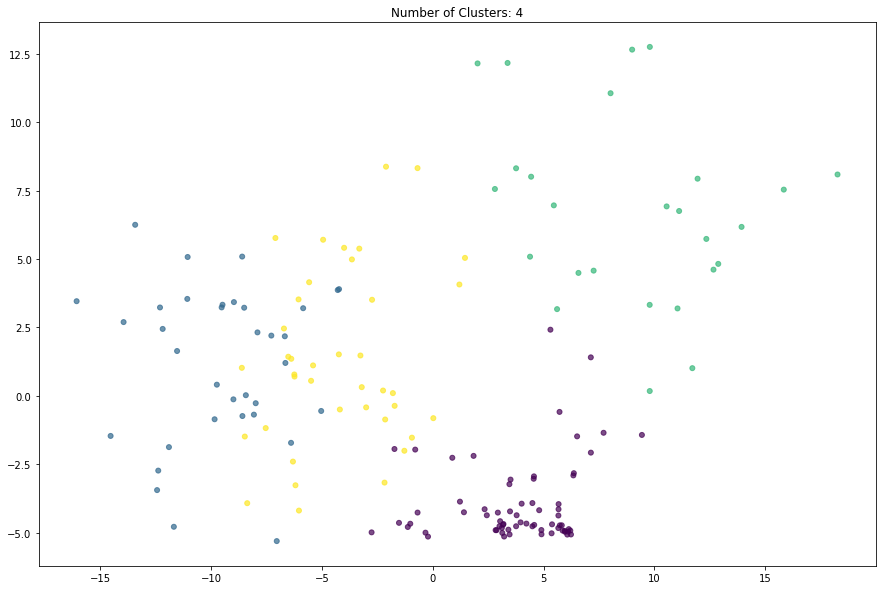

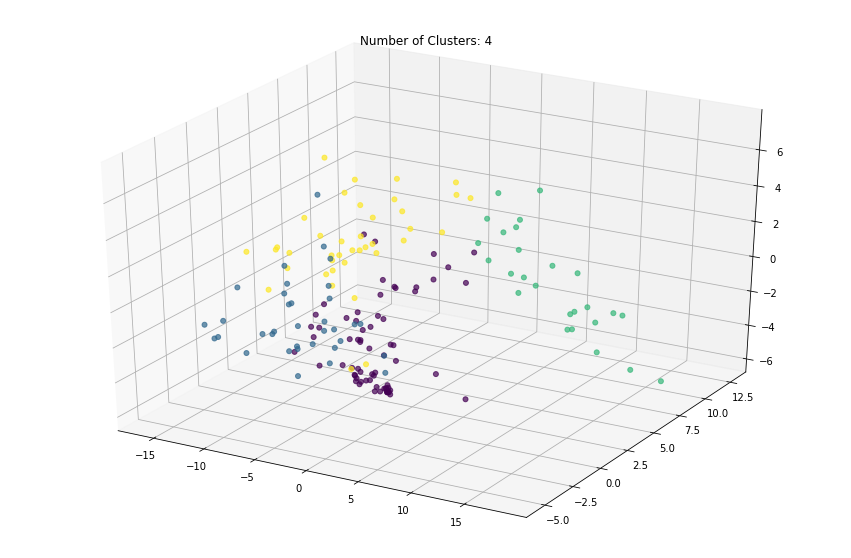

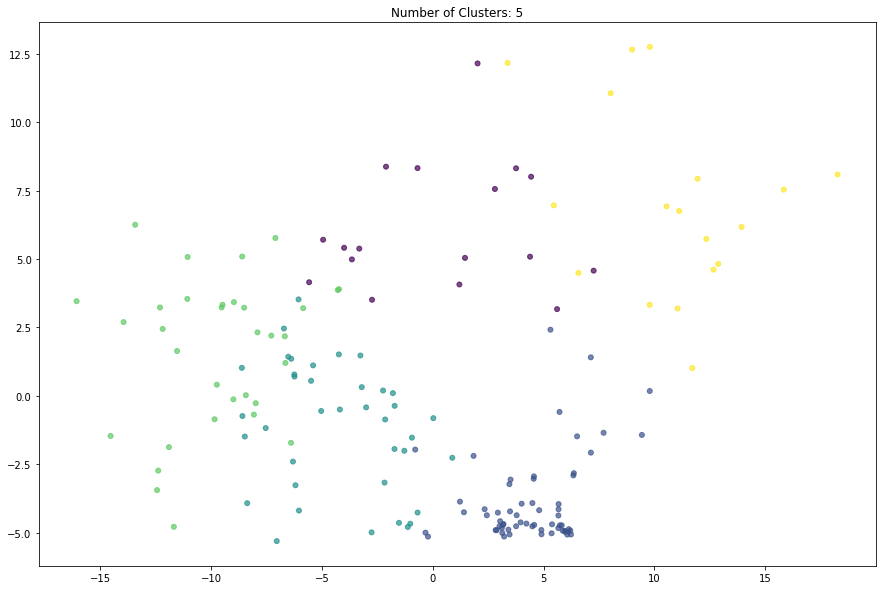

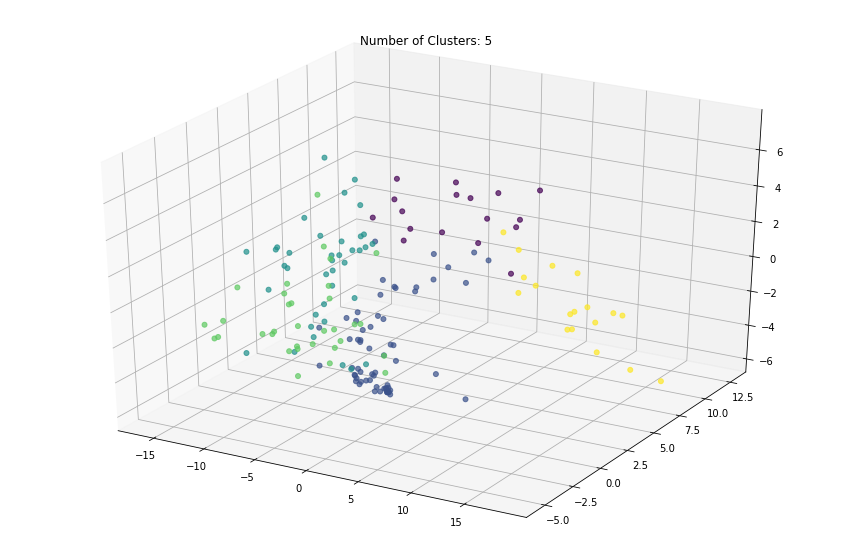

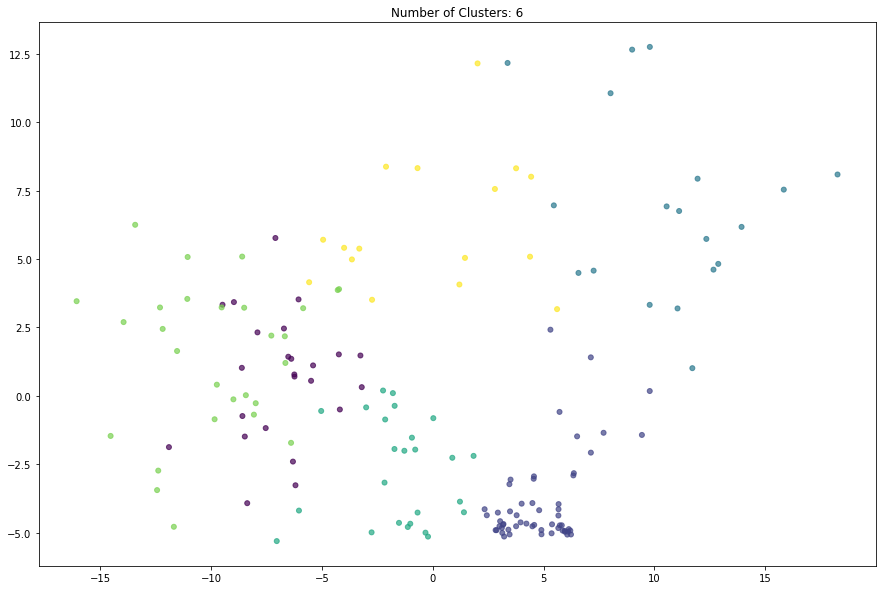

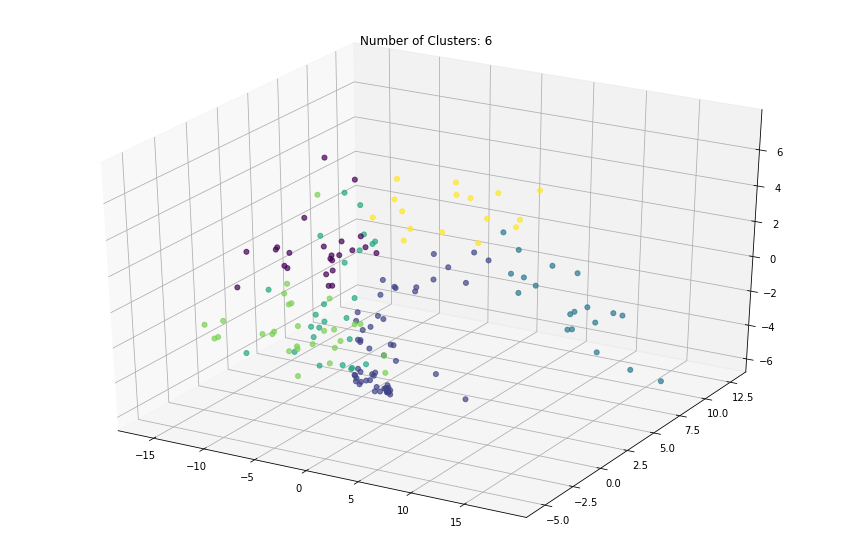

In [98]:
print('encodes size:', encodes.shape)
print('mean_fluorescence len:', len(mean_fluorescence))
# normalize
mean_fluorescence = np.array(mean_fluorescence)/255
encodes_fluo = np.concatenate((encodes, mean_fluorescence[:, np.newaxis]), axis=1)
encodes_fluo = encodes_fluo[~np.isnan(mean_fluorescence), :]
print('encodes_fluo size (not nan):', encodes_fluo.shape)

variance = np.var(encodes_fluo, axis=0)
plt.figure(figsize=(20, 7))
plt.bar(range(len(variance) - 1), variance[:-1], alpha=0.7, label='motility')
plt.bar(len(variance), variance[-1], alpha=0.7, label='fluorescence')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Features')
plt.show()


scaler = StandardScaler()
measures_scaled = scaler.fit_transform(encodes_fluo)
# features variance
pca = PCA()
measures_scaled = pca.fit_transform(measures_scaled)
pca_variance = pca.explained_variance_

plt.figure(figsize=(20, 7))
plt.bar(range(len(pca_variance)), pca_variance, alpha=0.7)
plt.ylabel('Variance ratio')
plt.xlabel('Features')
plt.show()

for i in range(1, 7):
    plt.figure(figsize=(15, 10))
    y_pred = KMeans(n_clusters=i).fit_predict(measures_scaled)
    plt.scatter(measures_scaled[:, 0], measures_scaled[:, 1], c=y_pred, s=25, alpha=0.7)
    plt.title(f"Number of Clusters: {i}")
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(measures_scaled[:, 0], measures_scaled[:, 1], measures_scaled[:, 2], c=y_pred, s=25, alpha=0.7)
    plt.title(f"Number of Clusters: {i}")

plt.show();

### Los valores de los encodes varían cada vez que se corre la generación de encodes.

In [92]:
encodes = np.load('data/test/test_encodes.npy')
encodes_1 = np.load('data/test/test_encodes_1.npy')
encodes_2 = np.load('data/test/test_encodes_2.npy')

# print('encodes_old', encodes_old)
# print('encodes', encodes)
print('\n')

print('encodes - encodes_1:   ', np.linalg.norm(encodes - encodes_1))
print('encodes - encodes_2:   ', np.linalg.norm(encodes - encodes_2))
print('encodes_1 - encodes_2: ', np.linalg.norm(encodes_1 - encodes_2))
print('\n')

print('encodes[0, :] - encodes[0, :]:     ', np.linalg.norm(encodes[0, :] - encodes[0, :]))
print('encodes_1[0, :] - encodes_1[0, :]: ', np.linalg.norm(encodes_1[0, :] - encodes_1[0, :]))
print('encodes_2[0, :] - encodes_2[0, :]: ', np.linalg.norm(encodes_2[0, :] - encodes_2[0, :]))

print('encodes[0, :] - encodes_1[0, :]:   ', np.linalg.norm(encodes[0, :] - encodes_1[0, :]))
print('encodes[0, :] - encodes_2[0, :]:   ', np.linalg.norm(encodes[0, :] - encodes_2[0, :]))
print('encodes_1[0, :] - encodes_2[0, :]: ', np.linalg.norm(encodes_1[0, :] - encodes_2[0, :]))
print('\n')

print('track 0 - track 1')
print('encodes[0, :] - encodes[1, :]:     ', np.linalg.norm(encodes[0, :] - encodes[1, :]))
print('encodes_1[0, :] - encodes_1[1, :]: ', np.linalg.norm(encodes_1[0, :] - encodes_1[1, :]))
print('encodes_2[0, :] - encodes_2[1, :]: ', np.linalg.norm(encodes_2[0, :] - encodes_2[1, :]))

print('encodes[0, :] - encodes_1[1, :]:   ', np.linalg.norm(encodes[0, :] - encodes_1[1, :]))
print('encodes[0, :] - encodes_2[1, :]:   ', np.linalg.norm(encodes[0, :] - encodes_2[1, :]))
print('encodes_1[0, :] - encodes_2[1, :]: ', np.linalg.norm(encodes_1[0, :] - encodes_2[1, :]))
print('\n')

print('track 0 - track 2')
print('encodes[0, :] - encodes[2, :]:     ', np.linalg.norm(encodes[0, :] - encodes[2, :]))
print('encodes_1[0, :] - encodes_1[2, :]: ', np.linalg.norm(encodes_1[0, :] - encodes_1[2, :]))
print('encodes_2[0, :] - encodes_2[2, :]: ', np.linalg.norm(encodes_2[0, :] - encodes_2[2, :]))

print('encodes[0, :] - encodes_1[2, :]:   ', np.linalg.norm(encodes[0, :] - encodes_1[2, :]))
print('encodes[0, :] - encodes_2[2, :]:   ', np.linalg.norm(encodes[0, :] - encodes_2[2, :]))
print('encodes_1[0, :] - encodes_2[2, :]: ', np.linalg.norm(encodes_1[0, :] - encodes_2[2, :]))
print('\n')

print('track 1 - track 2')
print('encodes[1, :] - encodes[2, :]:     ', np.linalg.norm(encodes[1, :] - encodes[2, :]))
print('encodes_1[1, :] - encodes_1[2, :]: ', np.linalg.norm(encodes_1[1, :] - encodes_1[2, :]))
print('encodes_2[1, :] - encodes_2[2, :]: ', np.linalg.norm(encodes_2[1, :] - encodes_2[2, :]))

print('encodes[1, :] - encodes_1[2, :]:   ', np.linalg.norm(encodes[1, :] - encodes_1[2, :]))
print('encodes[1, :] - encodes_2[2, :]:   ', np.linalg.norm(encodes[1, :] - encodes_2[2, :]))
print('encodes_1[1, :] - encodes_2[2, :]: ', np.linalg.norm(encodes_1[1, :] - encodes_2[2, :]))
print('\n')



encodes - encodes_1:    7.211552
encodes - encodes_2:    7.0640173
encodes_1 - encodes_2:  6.831568


encodes[0, :] - encodes[0, :]:      0.0
encodes_1[0, :] - encodes_1[0, :]:  0.0
encodes_2[0, :] - encodes_2[0, :]:  0.0
encodes[0, :] - encodes_1[0, :]:    1.9486469
encodes[0, :] - encodes_2[0, :]:    1.8177702
encodes_1[0, :] - encodes_2[0, :]:  1.7233871


track 0 - track 1
encodes[0, :] - encodes[1, :]:      0.97254306
encodes_1[0, :] - encodes_1[1, :]:  0.9192217
encodes_2[0, :] - encodes_2[1, :]:  0.92799354
encodes[0, :] - encodes_1[1, :]:    2.1785927
encodes[0, :] - encodes_2[1, :]:    2.1070974
encodes_1[0, :] - encodes_2[1, :]:  2.0207903


track 0 - track 2
encodes[0, :] - encodes[2, :]:      0.8776459
encodes_1[0, :] - encodes_1[2, :]:  0.922174
encodes_2[0, :] - encodes_2[2, :]:  0.87832665
encodes[0, :] - encodes_1[2, :]:    2.6026645
encodes[0, :] - encodes_2[2, :]:    2.3808975
encodes_1[0, :] - encodes_2[2, :]:  2.274453


track 1 - track 2
encodes[1, :] - encodes[2